In [1]:
using CSV, DataFrames, ReverseDiff, Flux, LinearAlgebra, Distributions, Plots
using Flux:update!

In [2]:
function NN(θ,x)
    W1, b1 = reshape(θ[1:7*16],(16,7)), θ[7*16+1:7*16+16]
    W2, b2 = θ[7*16+17:7*16+32], θ[end]
    return W2'*tanh.(W1*x+b1)+b2
end

NN (generic function with 1 method)

In [3]:
p_ξ = MvNormal(zeros(7*16+33), ones(7*16+33))
p_likelihood(x,ξ) = Normal(NN(ξ,x),1)
;

In [4]:
q_ξ(ϕ) = MvNormal(ϕ[1:Int(length(ϕ)/2)],ϕ[Int(length(ϕ)/2)+1:end].^2)
log_q(ξ,ϕ) = logpdf(q_ξ(ϕ),ξ)
;

In [5]:
csv_read = CSV.File("data/cascadedtanks/dataBenchmark.csv");

In [6]:
df = DataFrame(csv_read)
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]
;

In [8]:
# Training
FreeEnergy(N,y,x,ϕ,ϵ_s) = log_q(ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s,ϕ) - logpdf(p_ξ,ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s) - N*logpdf(p_likelihood(x,ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s),y)

ϕ = [zeros(7*16+33);0.1*ones(7*16+33)] # initialize ϕ
N = length(y_train)
for epoch=1:50
    FE = 0
    error = [0., 0.]
    for i=1:N
        if i==1
            x_i = [u_train[i];zeros(6)] # [u_t, u_{t-1}, u_{t-2}, y_{t-1}, y_{t-2}, e_{t-1}, e_{t-2}]
        elseif i == 2
            x_i = [u_train[i],u_train[i-1],0,y_train[i-1],0, error[1],error[2]]
        else
            x_i = [u_train[i],u_train[i-1],u_train[i-2],y_train[i-1],y_train[i-2], error[1],error[2]]
        end
        ϵ_s = randn(Int(length(ϕ)/2))
        FreeEnergy(ϕ) = FreeEnergy(N,y_train[i],x_i,ϕ,ϵ_s)
        FE += FreeEnergy(ϕ)
        ∇_ϕ = gradient(FreeEnergy,ϕ)[1]
        update!(ADAM(), ϕ, ∇_ϕ)
        error[2] = error[1]
        error[1] = y_train[i] - NN(ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s,x_i)
    end
    println(FE)
end

-4.5249036256199835e30
-5.673816160766835e30
-5.237691589482842e30
-1.8652817133889615e30
-5.960521525215106e31
-2.913181631631702e30
-4.094450193295204e30
-6.003726357076676e30
-6.566389382835931e30
-1.107125409280339e32
-1.1649038824422542e32
-2.5049593352978775e32
-4.506223945087282e30
-2.1996454464294527e30
-2.982843740190136e31
-7.155593488652832e30
-9.381355664883792e30
-1.365872157833956e31
-4.51848956059328e30
-3.9265067652069e31
-1.6724635294647922e31
-9.18855160224866e29
-6.0510016205739955e29
-6.171697797344783e29
-5.823377924055565e29
-5.076153999275593e29
-3.8910368896720906e30
-8.047406740403314e30
-9.837613637954697e30
-1.4829031521351008e30
-3.1670368788467935e30
-3.5384794985984333e30
-6.761848929252432e30
-2.5886191539123934e31
-2.1972364552303657e32
-1.6366523507234756e33
-4.153699341846207e30
-5.556381342877845e30
-8.026662516733502e30
-5.910986645559487e30
-1.941426868571164e30
-4.1203366135319894e30
-1.2814494838989578e32
-2.3985075550737594e32
-2.753288943846024e

In [12]:
println(ϕ)

[-0.019998786950300804, 0.01899970987694256, 0.020001994948652662, -0.03800161517906922, 0.030997921199484246, 0.07800071876792686, -0.010996062964741794, -0.021002391515425566, -0.02299731295634709, -0.018999346558841557, -0.029001702064456056, 0.012996934610294218, 0.02199894505484774, 0.01599934327838734, -0.013000733590862469, 0.019999308757651418, -0.023999226606435508, 0.018000096674862787, 0.0200018808535894, -0.028008891164120826, 0.025000057263514817, 0.07399767256630997, -0.009999640527064773, -0.020000111404517483, -0.01699946766280324, -0.02099943022308752, -0.019999120594519547, 0.020002267460412535, 0.026014123097946124, 0.016999833612069852, -0.011001772922615533, 0.021000469449737852, -0.013999131571289243, 0.016999997153813975, -0.002998852820014903, -0.016001892981328907, -0.0070001959299459725, 0.05099680944119908, 0.0040002390058814525, -0.02400046075985307, -0.022999573403480706, -0.020000105686950355, -0.030999003202653787, 0.017001516983800407, 0.0199999598452272

In [10]:
# Prediction
q = q_ξ(ϕ)

predictions = []
for i=1:length(y_val)
    error = [0., 0.]
    if i==1
        x_i = [u_val[i];zeros(6)] # [u_t, u_{t-1}, u_{t-2}, y_{t-1}, y_{t-2}, e_{t-1}, e_{t-2}]
    elseif i == 2
        x_i = [u_val[i],u_val[i-1],0,y_val[i-1],0, error[1],error[2]]
    else
        x_i = [u_val[i],u_val[i-1],u_val[i-2],y_val[i-1],y_val[i-2], error[1],error[2]]
    end
    predict = zeros(100)
    for n=1:100
        θ_s = rand(q)
        predict[n] = NN(θ_s,x_i)
    end
    error[2] = error[1]
    error[1] = y_val[i] - mean(predict)
    push!(predictions,Normal(mean(predict),std(predict)))
end

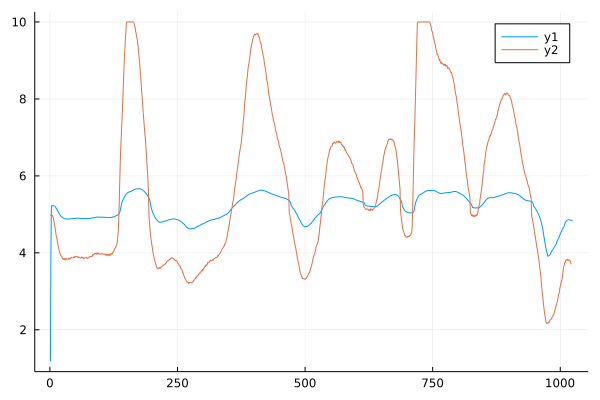

In [11]:
plot(mean.(predictions),ribbon=var.(predictions))
plot!(y_val[3:end])